In [ ]:
%load_ext autoreload
%autoreload 3 --print

In [447]:
import torch as th
import numpy as np
import numpy.linalg as la
from torch import jit
from torch import optim
import joblib as jl
from torch import nn
from dynrn.rnntasks import DriscollTasks, itiexp
from dynrn.limit_sets import is_converging, velocities
from cmap import Colormap
from sklearn.decomposition import PCA
import dynrn.basic_rnns as rnns
from dynrn.viz import util as vu, dynamics as vd
from scipy.stats import uniform, norm

from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import scipy.stats
from pathlib import Path
import tqdm
import seaborn as sns

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from dynrn.viz import styles
from dynrn.viz.styles import getc
t20 = lambda x: getc(f"seaborn:tab20{x}")
colors, plotter = styles.init_plt(
    '../plots/notebook/driscoll-fixed',
    fmt = 'pdf')
plot_root = Path(plotter.plot_dir)

In [ ]:
# cuda setup
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(device.type)

### Load RNN and get hidden trajectories

In [ ]:
model_root = Path("../data/task-models")
model_path = model_root / "driscoll-n1024_5c135.07181253"
model = jit.load(f"{model_path}.pt", map_location=device)
model.load_state_dict(th.load(f"{model_path}.tar", map_location=device))

task_kws = jl.load(model_root / '../tasks' / "memorypro-long.jl")

In [ ]:
# workaround while installing matcing version with cluster
# task_kws = dict(
#     iti=itiexp(6, 10),
#     context=itiexp(6, 10),
#     stim=itiexp(6, 10),
#     memory=itiexp(6, 10),
#     response=itiexp(6, 10),
#     magnitude=uniform(1, 1),
#     angle=uniform(0, 0.78),
#     angle_noise=norm(0, 0.),
#     flag_noise=norm(0, 0.1),
# )

In [ ]:
x, y, periods = DriscollTasks.memorypro(
    session_length=500,
    n_sessions=200,
    seed = 1,
    **task_kws
)
x = th.tensor(x, dtype=th.float32)
y = th.tensor(y, dtype=th.float32)


### hidden activation principal spaces for each task phase

In [ ]:
period_colors = [t20("b:5"),  t20("c:1"), t20("b:2"), t20("b:14"), t20("b:10")]

In [ ]:
sns.palplot(period_colors   )

In [ ]:
h_init = th.zeros(x.shape[0], model.nh)
_, all_h = model.seq_forward(x, h_init)
max_nc = 40
n_periods = int(periods.max()) + 1

period_h = [all_h.detach().numpy()[periods == i] for i in range(n_periods)]
period_pca = [PCA(n_components=max_nc).fit(h) for h in tqdm.tqdm(period_h)]
period_names = ['ITI', 'Context', 'Stim', 'Memory', 'Response']

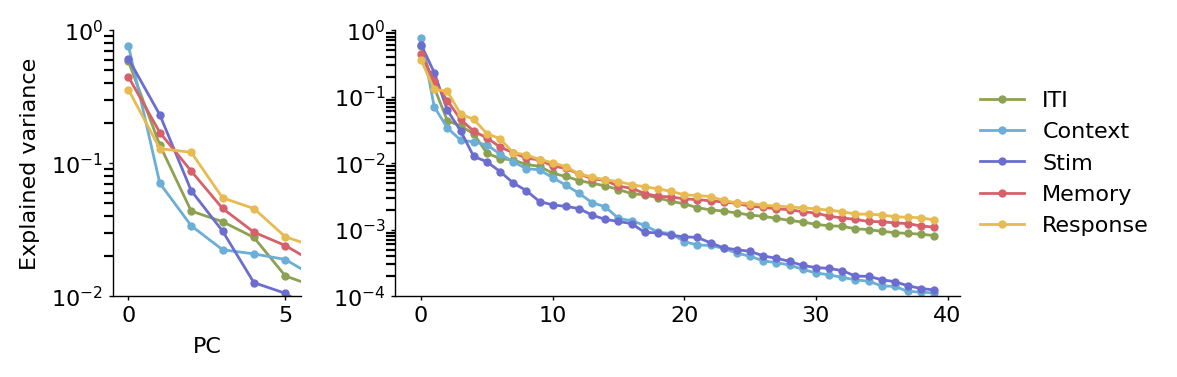

In [208]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2), width_ratios=[1, 3])
for j, a in enumerate(ax):
    for i, (h, pca) in enumerate(zip(period_h, period_pca)):
        a.plot(pca.explained_variance_ratio_, 'o-', ms = 3, lw = 1, color = period_colors[i], label = period_names[i])
    a.set_yscale('log')
ax[0].set_xlabel('PC')
ax[0].set_ylabel('Explained variance')  
ax[0].set_ylim(1e-2, 1)
ax[0].set_xlim(-0.5, 5.5)
ax[1].set_ylim(1e-4, 1)
vu.legend(ax[1])
plotter.finalize(fig, None)

In [ ]:
def split_trials(data, periods):
    trial_data, trial_periods = [], []
    n_periods = int(periods.max()) + 1
    for h, p in zip(data, periods):
        trials = np.where(np.diff((p == n_periods - 1).astype('int')) == -1)[0]
        trial_data.extend(np.array_split(h, trials + 1)[:-1])
        trial_periods.extend(np.array_split(p, trials + 1)[:-1])
    return trial_data, trial_periods

trial_h = [[h[p == i] for h, p in zip(*split_trials(all_h, periods))] for i in range(n_periods)]

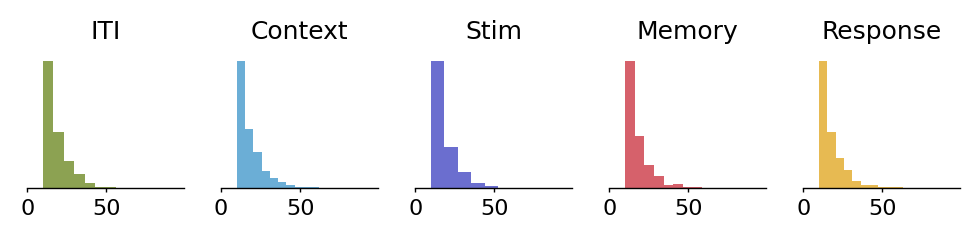

In [207]:
fig, ax = plt.subplots(1, n_periods, figsize=(1 * n_periods, 1.3), sharex = True)
for i, trajs in enumerate(trial_h):
    ax[i].hist([len(t) for t in trajs], color = period_colors[i], bins = 10)
    ax[i].set_title(period_names[i])
    ax[i].set_yticks([])
    sns.despine(ax = ax[i], left = True)
ax[0].set_xlim(0, None)
plotter.finalize(fig, None, despine = False)

In [ ]:
trial_hpc = [
    [pca.transform(h.detach()) for h in trajs]
    for pca, trajs in zip(period_pca, trial_h)
]

trial_max_len = int(max(len(t) for trajs in trial_hpc for t in trajs))
print("longest trial (steps):", trial_max_len)
trial_hpc_pad = np.array([
    np.array([np.pad(t, [(0, trial_max_len - len(t)), (0, 0)], constant_values = (0, np.nan)) for t in trajs])
    for trajs in trial_hpc
])

In [ ]:
trial_angle = np.array([np.arctan2(x_[p == 2, 3], x_[p == 2, 2]).mean() for x_, p in zip(*split_trials(x, periods))])
angle_pal = Colormap('matlab:cool')
trial_angle_clr = angle_pal(trial_angle / task_kws['angle'].args[1])

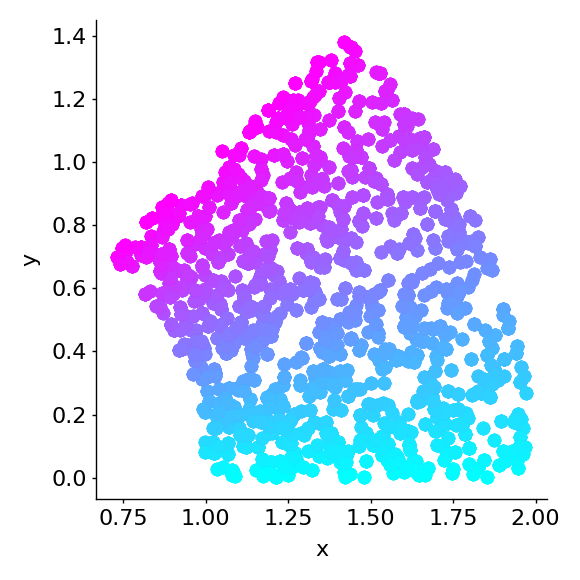

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
for x_, p, clr in zip(*split_trials(x, periods), trial_angle_clr):
    ax.scatter(x_[p == 2, 2], x_[p == 2, 3], color = clr)
ax.set_xlabel('x')
ax.set_ylabel('y')
plotter.finalize(fig, None)

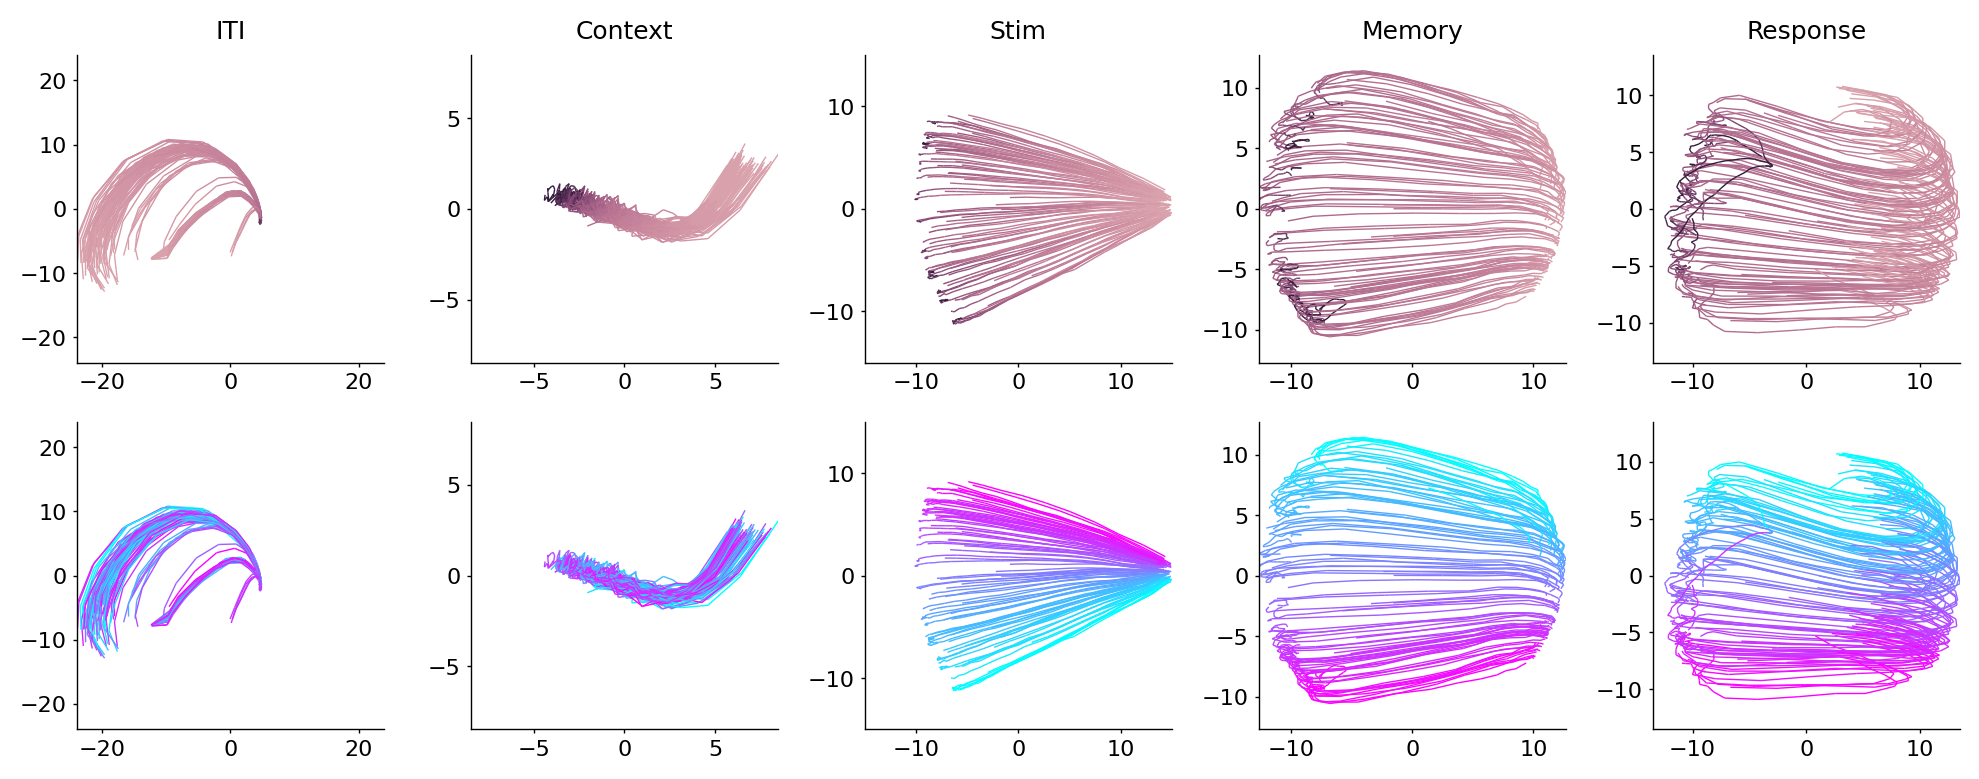

In [212]:
plot_n = 100

fig, ax = plt.subplots(2, n_periods, figsize=(2 * n_periods, 4))
timecolors = colors.ch0(30)
timecolors = np.concatenate([timecolors, timecolors[[-1] * (trial_max_len - 30)]], axis = 0)

for i, trajs in enumerate(trial_hpc_pad):
    vd.trajecories(ax[0, i], trajs[:plot_n, :, :2], timecolors, lw = 0.5)
    vd.trajecories(ax[1, i], trajs[:plot_n, :, :2], trial_angle_clr[:plot_n], color = 'traj', lw = 0.5)
    ax[0, i].set_title(period_names[i])

plotter.finalize(fig, None)

### representative inputs for each task phase

In [432]:
len_traj = 200
n_angle = 8
magnitude = 1.5
n_hidden_init = 117

period_x = [th.zeros(len_traj, 4) for _ in period_names]

period_x[1][..., 0] = 1 # context
period_x[3][..., 0] = 1 # memory
period_x[4][..., 1] = 1 # response

period_x[2] = th.zeros(n_angle, len_traj, 4) # stimulus
trial_angles = th.linspace(0, np.pi / 4, n_angle + 1)[:-1]
period_x[2][..., 2] = magnitude * th.cos(trial_angles)[:, None]
period_x[2][..., 3] = magnitude * th.sin(trial_angles)[:, None]

period_x = [np.tile(x_, [n_hidden_init, 1, 1]) for x_ in period_x]


angle_pal = Colormap('matlab:cool')
trial_angle_clr = [np.array([[0, 0, 0, 0]]) for _ in period_x]
trial_angle_clr[2] = angle_pal(trial_angles / np.pi * 4)
trial_angle_clr = [np.tile(c_, [n_hidden_init, 1]) for c_ in trial_angle_clr]

Could generate initial hidden states based on

- each phase's first few PCs
- the previous phase's first few PCs
- unstructured random initialization

#### based on own PCs

In [482]:


rng = np.random.default_rng(1570)
h_inits = rng.uniform(-5, 5, (n_periods, n_hidden_init, max_nc))
h_inits = np.array([
    pca.inverse_transform(h_init * np.sqrt(pca.explained_variance_[None])).astype(np.float32)
    for h_init, pca in zip(h_inits, period_pca)
])

period_h0 = [np.repeat(h_, x_.shape[0] // n_hidden_init, axis = 0) for h_, x_ in zip(h_inits, period_x)]



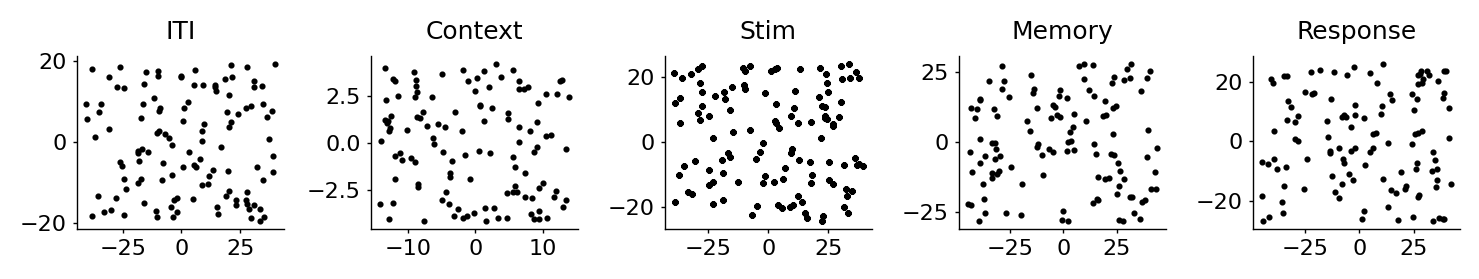

In [483]:
fig, ax = plt.subplots(1, n_periods, figsize=(1.5 * n_periods, 1.5))

for i, h_ in enumerate(period_h0):
    hpc = period_pca[i].transform(h_)
    ax[i].scatter(hpc[:, 0].ravel(), hpc[:, 1].ravel(), s = 2, color = 'k')
    ax[i].set_title(period_names[i])

plotter.finalize(fig, None)

In [484]:
trajs = [
    model.seq_forward(th.tensor(x_), th.tensor(h_))[1].detach().numpy()
    for x_, h_ in zip(period_x, period_h0)
]
trajs_pc = [
    pca.transform(t_.reshape(-1, t_.shape[-1])).reshape(t_.shape[:-1] + (max_nc,))
    for t_, pca in zip(trajs, period_pca)
]



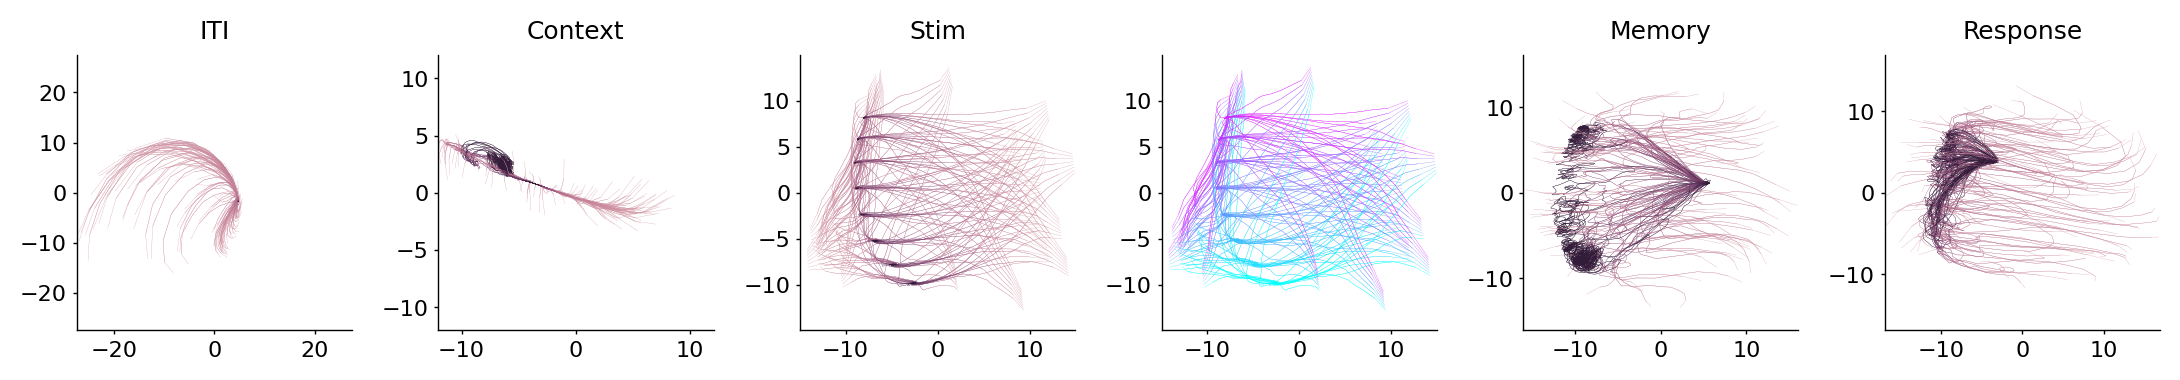

In [489]:
timecolors = colors.ch0(30)
timecolors = np.concatenate([timecolors, timecolors[[-1] * abs(len_traj - 30)]], axis = 0)

plot_n = 200

fig, axes = plt.subplots(1, n_periods + 1, figsize=(2 * n_periods + 1, 2))

for i, (t_, ax) in enumerate(zip(trajs_pc, axes[[0, 1, 2, 4, 5]])):
    vd.trajecories(ax, t_[:plot_n, :, :2], timecolors, lw = 0.1)
    ax.set_title(period_names[i])

vd.trajecories(axes[3], trajs_pc[2][:plot_n, :, :2], trial_angle_clr[2][:plot_n], color = 'traj', lw = 0.1)

plotter.finalize(fig, None)


#### based on previous PCs

In [565]:
rng = np.random.default_rng(1573)
h_inits = rng.uniform(-5, 5, (n_periods, n_hidden_init, max_nc))
apply_pcas = [period_pca[i] for i in [0, 0, 1, 2, 3]]
h_inits = np.array([
    pca.inverse_transform(h_init * np.sqrt(pca.explained_variance_[None])).astype(np.float32)
    for h_init, pca in zip(h_inits, apply_pcas)
])

period_h0 = [np.repeat(h_, x_.shape[0] // n_hidden_init, axis = 0) for h_, x_ in zip(h_inits, period_x)]



In [566]:
# 2D color mapping of generating PC space

pc_cmaps = [Colormap('dense'), Colormap('haline')]
trial_pc_clr = []
for i, (h_, pca) in enumerate(zip(period_h0, apply_pcas)):
    hpc = pca.transform(h_)
    c0 = pc_cmaps[0]((hpc[..., 0] - hpc[..., 0].min()) / np.ptp(hpc[..., 0]))
    c1 = pc_cmaps[1]((hpc[..., 1] - hpc[..., 1].min()) / np.ptp(hpc[..., 1]))
    trial_pc_clr.append( np.clip(0.6 * c0 + 0.6 * c1, 0, 0.9) )

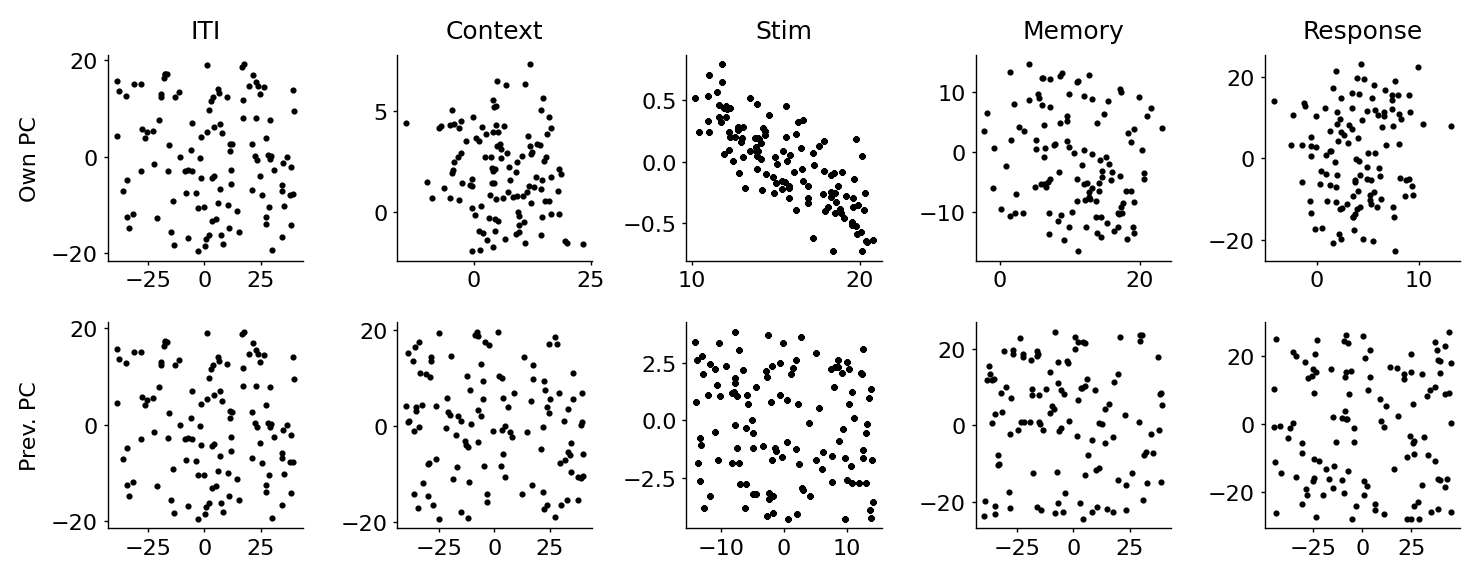

In [567]:
fig, ax = plt.subplots(2, n_periods, figsize=(1.5 * n_periods, 3))

for i, h_ in enumerate(period_h0):
    hpc = period_pca[i].transform(h_)
    ax[0, i].scatter(hpc[:, 0].ravel(), hpc[:, 1].ravel(), s = 2, color = 'k')
    ax[0, i].set_title(period_names[i])
    hpc = apply_pcas[i].transform(h_)
    ax[1, i].scatter(hpc[:, 0].ravel(), hpc[:, 1].ravel(), s = 2, color = 'k')

ax[0, 0].set_ylabel("Own PC")
ax[1, 0].set_ylabel("Prev. PC")

plotter.finalize(fig, None)

In [568]:
trajs = [
    model.seq_forward(th.tensor(x_), th.tensor(h_))[1].detach().numpy()
    for x_, h_ in zip(period_x, period_h0)
]
trajs_pc = [
    pca.transform(t_.reshape(-1, t_.shape[-1])).reshape(t_.shape[:-1] + (max_nc,))
    for t_, pca in zip(trajs, period_pca)
]



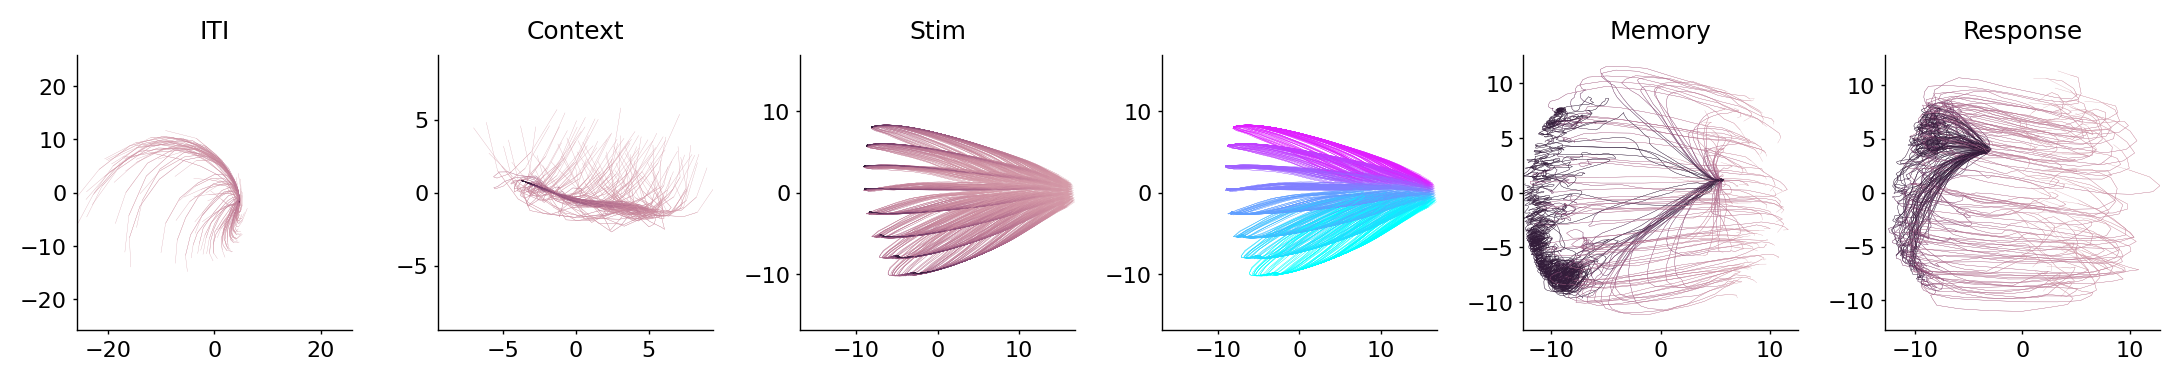

In [569]:
timecolors = colors.ch0(30)
timecolors = np.concatenate([timecolors, timecolors[[-1] * abs(len_traj - 30)]], axis = 0)

plot_n = -1

fig, axes = plt.subplots(1, n_periods + 1, figsize=(2 * n_periods + 1, 2))

for i, (t_, ax) in enumerate(zip(trajs_pc, axes[[0, 1, 2, 4, 5]])):
    vd.trajecories(ax, t_[:plot_n, :, :2], timecolors, lw = 0.1)
    ax.set_title(period_names[i])

vd.trajecories(axes[3], trajs_pc[2][:plot_n, :, :2], trial_angle_clr[2][:plot_n], color = 'traj', lw = 0.1)

plotter.finalize(fig, None)


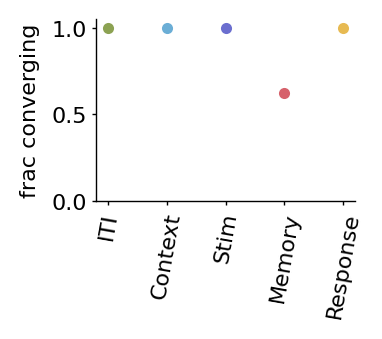

In [570]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.8))

fixedpt_mask = [is_converging(t_) for t_ in trajs]

for i, m_ in enumerate(fixedpt_mask):
    ax.plot([i], [m_.mean()], 'o', color = period_colors[i])
ax.set_xticks(range(n_periods))
ax.set_xticklabels(period_names, rotation = 80)
ax.set_ylabel("frac converging")
ax.set_ylim(0, 1.05)

plotter.finalize(fig, None,)

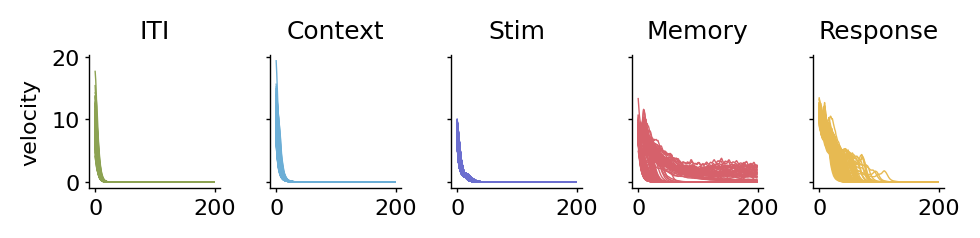

In [571]:
fig, ax = plt.subplots(1, n_periods, figsize=(1 * n_periods, 1.3), sharex = True, sharey = True)
for i, t_ in enumerate(trajs):

    ax[i].plot(velocities(t_).T, '-', color = period_colors[i], lw = 0.5)
    ax[i].set_title(period_names[i])
ax[0].set_ylabel("velocity")
plotter.finalize(fig, None)

##### memory period ring attractor

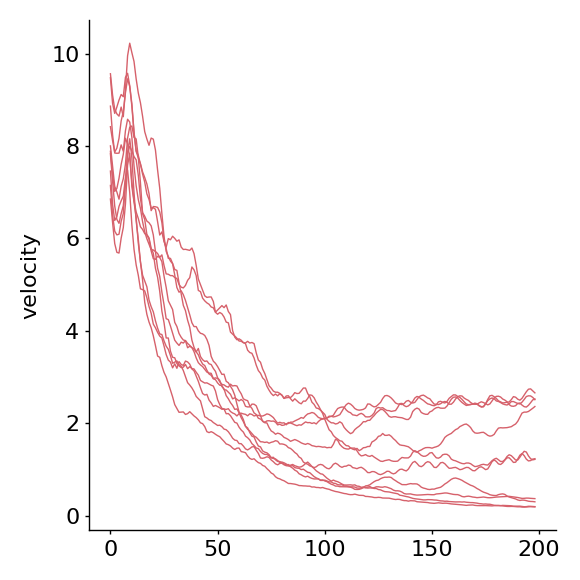

In [574]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
plot_n = 10
ax.plot(velocities(trajs[3])[~fixedpt_mask[3]][:plot_n].T, '-', lw = 0.5, color = period_colors[3])
ax.set_ylabel("velocity")
plotter.finalize(fig, None)

In [582]:
end_len = 50
pca = PCA(n_components=5)
mempc = pca.fit_transform(trajs[3][~fixedpt_mask[3], -end_len:].reshape(-1, trajs[3].shape[-1])).reshape(-1, end_len,  5)


((44, 50, 1024), (2200, 1024), (44, 50, 5))

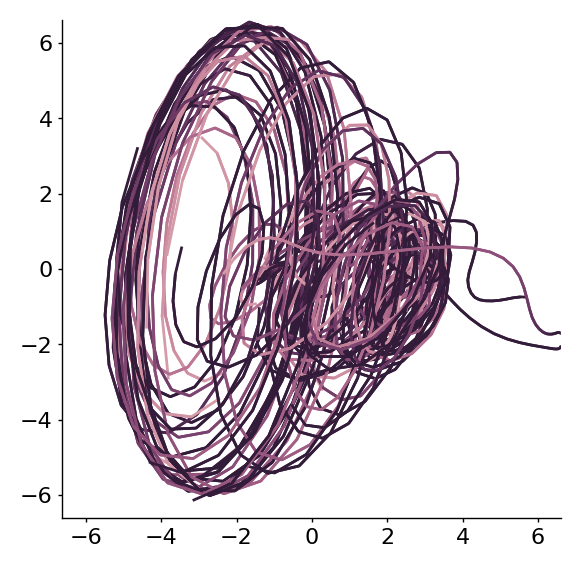

In [585]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
timecolors = colors.ch0(30)
timecolors = np.concatenate([timecolors, timecolors[[-1] * abs(end_len - 30)]], axis = 0)
vd.trajecories(ax, mempc[:, :, [2, 3]], colors = timecolors)
plotter.finalize(fig, None)

##### which initializations fall into fixed points?

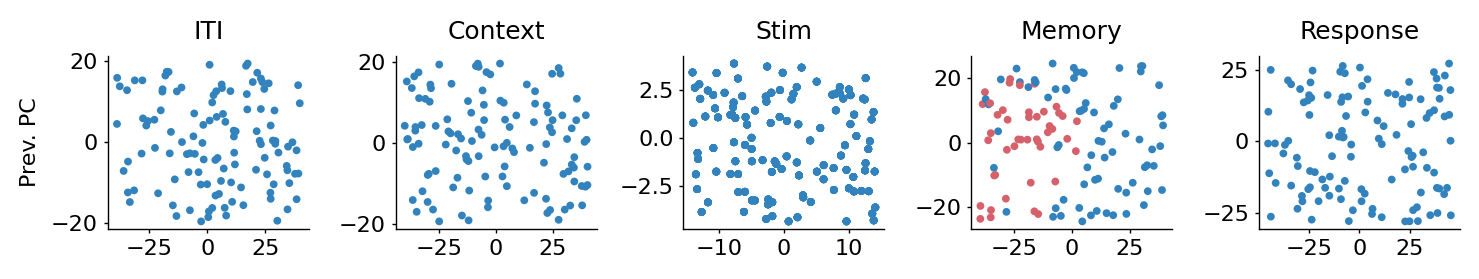

In [557]:
converging_pal = np.array([t20('b:14'), t20('c:0')])

fig, ax = plt.subplots(1, n_periods, figsize=(1.5 * n_periods, 1.5))

for i, h_ in enumerate(period_h0):
    ax[i].set_title(period_names[i])
    hpc = apply_pcas[i].transform(h_)
    ax[i].scatter(hpc[:, 0].ravel(), hpc[:, 1].ravel(), s = 4, c = converging_pal[fixedpt_mask[i].astype('int')])

ax[0].set_ylabel("Prev. PC")

plotter.finalize(fig, None)


In [550]:
hpc.shape, converging_pal.shape

((117, 40), (2, 4))